<a href="https://colab.research.google.com/github/hargurjeet/DeepLearning/blob/main/Fruit_360_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **6 Best Technique To Improve The Accuracy Of Neural Network w/o Overfitting**

We often face a situation while trying to improve the accuracy of the neural network we end up overfitting the model on the training data. This leads to a poor prediction when we run the model of the test data. Hence I take a dataset and apply these techniques that not only improve the accuracy but also handles the overfitting issues.

In this notebook, we'll use the following techniques to train a state-of-the-art model in less than 5 minutes to achieve over 95% accuracy in classifying images from the Fruit 360 dataset :

- Data augmentation 
>  Data augmentation in data analysis are techniques used to increase the amount of data by adding slightly modified copies of already existing data or newly created synthetic data from existing data. It acts as a regularizer and helps reduce overfitting when training a machine learning model.[Read more](https://neptune.ai/blog/data-augmentation-in-python)
- Batch normalization
> Batch normalization is a technique for training very deep neural networks that standardizes the inputs to a layer for each mini-batch. This has the effect of stabilizing the learning process and dramatically reducing the number of training epochs required to train deep networks.[Read more](https://machinelearningmastery.com/batch-normalization-for-training-of-deep-neural-networks/)
- Learning rate scheduling
> Learning rate schedules seek to adjust the learning rate during training by reducing the learning rate according to a pre-defined schedule. Common learning rate schedules include time-based decay, step decay and exponential decay. [Read more](https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1)
- Weight Decay
> We use weight decay to keep the weights small and avoid exploding gradient. Because the L2 norm of the weights are added to the loss, each iteration of your network will try to optimize/minimize the model weights in addition to the loss. This will help keep the weights as small as possible, preventing the weights to grow out of control, and thus avoid exploding gradient.[Learn more](https://medium.com/analytics-vidhya/deep-learning-basics-weight-decay-3c68eb4344e9)
- Gradient clipping
> Using gradient clipping you can prevent exploding gradients in neural networks.Gradient clipping limits the magnitude of the gradient.There are many ways to compute gradient clipping, but a common one is to rescale gradients so that their norm is at most a particular value. [Learn more](https://androidkt.com/how-to-apply-gradient-clipping-in-pytorch/)
- Adaptive optimizer
> This family of optimizers has been introduced to solve the issues of the gradient descent’s algorithms. Their most important feature is that they don’t require a tuning of the learning rate value. Actually some libraries — i.e. Keras — still let you the possibility to manually tune it for more advanced trials.[Learn more](https://towardsdatascience.com/7-tips-to-choose-the-best-optimizer-47bb9c1219e)

#<a name="Top"></a> **Table Of Contents**


---



---


  1. [About the Dataset](#AboutDataset)
  2. [Data Pre Processing](#Data-Pre)
  3. [Exploring the dataset](#Data-Pre)
  4. [Applying Data augmentation](#Data-augmentation)
  5. [Acessing Few Sample Images](#SampleImages)
  6. [Acessing GPU](#gpu)
  7. [Configuring The Model](#Configuration)
  8. [Model Training and Results](#Results)
  9. [Predictions](#Predictions)
  10. [Summary](#Summary)

#<a name="AboutDataset"></a> **1: About the Dataset**


---



Total number of images: 90483.

Training set size: 67692 images (one fruit or vegetable per image).

Test set size: 22688 images (one fruit or vegetable per image).

Number of classes: 131 (fruits and vegetables).

Image size: 100x100 pixels.

Filename format: imageindex100.jpg (e.g. 32100.jpg) or rimageindex100.jpg (e.g. r32100.jpg) or r2imageindex100.jpg or r3imageindex100.jpg. "r" stands for rotated fruit. "r2" means that the fruit was rotated around the 3rd axis. "100" comes from image size (100x100 pixels).

Different varieties of the same fruit (apple for instance) are stored as belonging to different classes.

[back to top](#Top)

#<a name="Data-Pre"></a> **2: Data Pre Processing**


---



Since we are using PyTorch to build the neural network. I import all the related library in single go.

## 2.1 Importing the required lib

In [1]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
from torchvision.datasets import CIFAR10
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

## 2.2 Downloading the dataset

I use opendatasets library to download dataset from kaggle. Incase you are not aware of the process of connecting Colab with Kaggle

<details opened>
<summary>click here !</summary>
1. Go to your account, Scroll to API section and Click Expire API Token to remove previous tokens

2. Click on Create New API Token - It will download kaggle.json file on your machine.

3. Go to your Google Colab project file and run the following commands:

  1) ! pip install -q kaggle

  2) from google.colab import files

  files.upload()

Choose the kaggle.json file that you downloaded
3. ! mkdir ~/.kaggle

  ! cp kaggle.json ~/.kaggle/

Make directory named kaggle and copy kaggle.json file there.
4. ! chmod 600 ~/.kaggle/kaggle.json

  Change the permissions of the file.
5. ! kaggle datasets list
  - That's all ! You can check if everything's okay by running this command.

</details>


In [2]:
# Upload kaggle.jason
# please follow this link incase not aware: https://www.kaggle.com/general/74235
from google.colab import files
files.upload()

! pip install opendatasets --upgrade
import opendatasets as od

dataset_url = 'https://www.kaggle.com/moltean/fruits'
od.download(dataset_url)

Saving kaggle.json to kaggle (1).json
Requirement already up-to-date: opendatasets in /usr/local/lib/python3.7/dist-packages (0.1.11)


  3%|▎         | 21.0M/760M [00:00<00:03, 216MB/s]

100%|██████████| 760M/760M [00:07<00:00, 99.7MB/s]


Before we run any exploration the dataset has to be loaded to a dataloader. We use ImageFolder from PyTorch to load the images to the dataloader.

In [3]:
data_dir = '/content/fruits/fruits-360/'

train_dataset = ImageFolder(data_dir + "Training", transform=ToTensor())

test_dataset = ImageFolder(data_dir + "Test", transform=ToTensor())

[back to top](#Top)

#<a name="Exploring"></a> **3: Exploring the dataset**


---



## Q: How many images does the training and testing dataset contain?

In [4]:
dataset_size = len(train_dataset)
test_dataset_size = len(test_dataset)
print(train_dataset)
print(test_dataset)

Dataset ImageFolder
    Number of datapoints: 67692
    Root location: /content/fruits/fruits-360/Training
    StandardTransform
Transform: ToTensor()
Dataset ImageFolder
    Number of datapoints: 22688
    Root location: /content/fruits/fruits-360/Test
    StandardTransform
Transform: ToTensor()


## Q: How many output classes does the dataset contain?

In [5]:
# Accesssing the classes
data_dir = '/content/fruits/fruits-360/'

# print(os.listdir(data_dir))
classes = os.listdir(data_dir + "Training")
print(f'Total Number of Classe {len(classes)}')
print(f'Classes Names: {classes}')

Total Number of Classe 131
Classes Names: ['Apple Braeburn', 'Cherry Wax Red', 'Melon Piel de Sapo', 'Rambutan', 'Tamarillo', 'Pepino', 'Lemon', 'Tomato Cherry Red', 'Apple Golden 1', 'Peach Flat', 'Apple Red Delicious', 'Lemon Meyer', 'Banana Red', 'Orange', 'Peach 2', 'Pepper Red', 'Grape White', 'Kaki', 'Pepper Yellow', 'Salak', 'Potato White', 'Cucumber Ripe 2', 'Apple Golden 2', 'Pitahaya Red', 'Mulberry', 'Carambula', 'Pear Abate', 'Banana', 'Tomato Maroon', 'Pear Red', 'Pear Forelle', 'Pineapple', 'Ginger Root', 'Potato Red', 'Apple Pink Lady', 'Pear Kaiser', 'Mandarine', 'Strawberry', 'Apple Golden 3', 'Nectarine', 'Plum 3', 'Avocado ripe', 'Cantaloupe 2', 'Fig', 'Tomato 1', 'Tomato Heart', 'Passion Fruit', 'Grape Blue', 'Cantaloupe 1', 'Apple Granny Smith', 'Banana Lady Finger', 'Mango Red', 'Cherry Rainier', 'Corn Husk', 'Hazelnut', 'Pear', 'Cauliflower', 'Pear Williams', 'Tangelo', 'Avocado', 'Physalis', 'Chestnut', 'Onion White', 'Granadilla', 'Strawberry Wedge', 'Plum 2', 

## Q: What is the shape of an image tensor from the dataset?

In [6]:
img, label = train_dataset[0]
img_shape = img.shape
img_shape

torch.Size([3, 100, 100])

Let us print a sample image along with its class and label.

Label (numeric): 0
Label (textual): Apple Braeburn


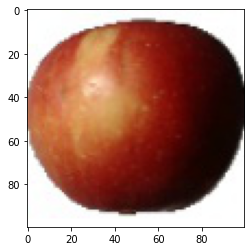

In [7]:
img, label = train_dataset[0]
plt.imshow(img.permute((1, 2, 0)))
print('Label (numeric):', label)
print('Label (textual):', classes[label])

## Q: Can you determine the number of images belonging to each class?

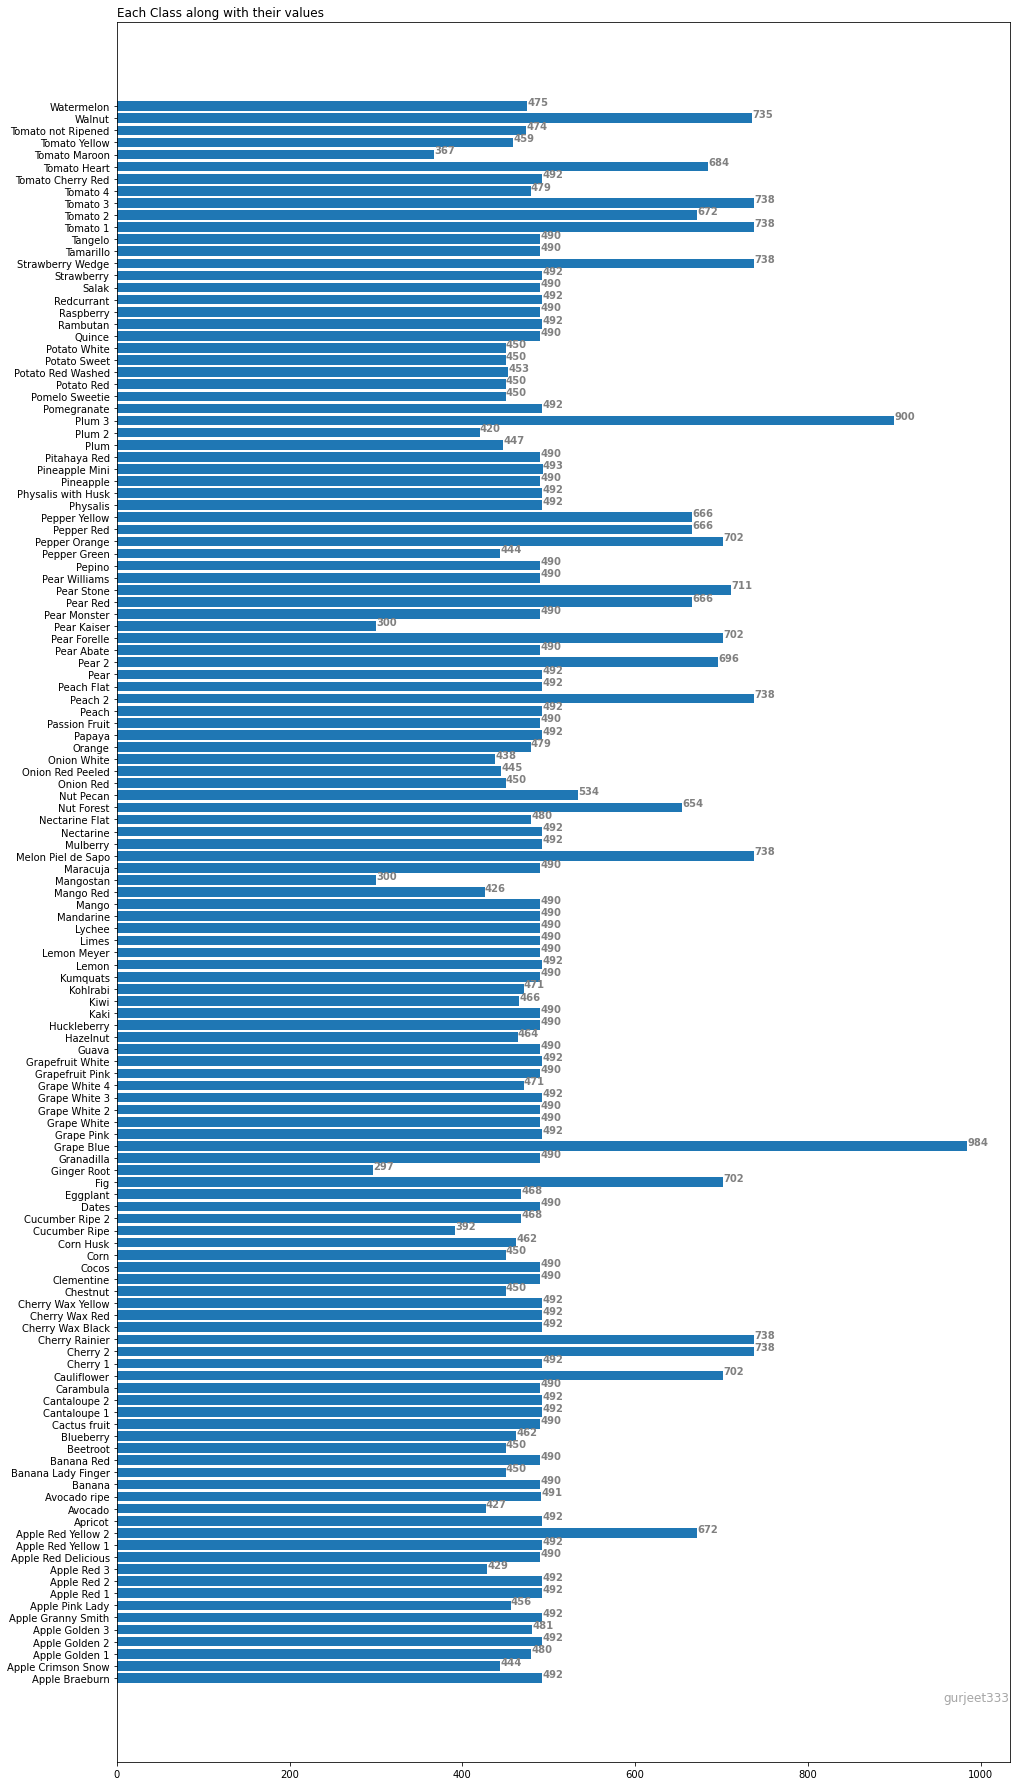

In [8]:
dataset_size = len(train_dataset)
classes = train_dataset.classes
num_classes = len(train_dataset.classes)

img_dict = {}
for i in range(num_classes):
    img_dict[classes[i]] = 0
    
for i in range(dataset_size):
    img, label = train_dataset[i]
    img_dict[classes[label]] += 1


## Plotting classes along with images info

from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize =(16, 32))

ax.barh(list(img_dict.keys()), list(img_dict.values()))



# Add Plot Title
ax.set_title('Each Class along with their values',
             loc ='left', )

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')

# Add Text watermark
fig.text(0.9, 0.15, 'gurjeet333', fontsize = 12,
         color ='grey', ha ='right', va ='bottom',
         alpha = 0.7)
plt.show()


[back to top](#Top)

#<a name="Data-augmentation"></a> **4: Applying Data augmentation**


---



## 4.1 Builiding data transforms

We will first write the transform function so that data augmmentation can be implemented.


In [9]:
# Data transforms (data augmentation)
train_tfms = tt.Compose([
                         tt.RandomCrop(100, padding=4, padding_mode='reflect'), 
                         tt.Resize((100,100)),
                         tt.RandomHorizontalFlip(), 
                         # tt.RandomRotate
                         # tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
                         # tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                         tt.ToTensor(), 

                         ])
valid_tfms = tt.Compose([tt.ToTensor(), tt.Resize((100,100)),
                         ])

Please feel free to try addtional parameters like tt.RandomRotate, tt.RandomResized, tt.ColorJitter (I have added them in the code)

## 4.2 Applying the transfroms to the dataset

The tranform we build needs to be applied to training and testing datasets. 
**Note** - We dont apply data augmentation in testing dataset.

In [10]:
dataset = ImageFolder(data_dir + "/Training", transform=train_tfms)

Testing = ImageFolder(data_dir + "/Test", transform=valid_tfms)

## 4.3 Splitting the dataset

We'll use a validation set of 20% from the training set. To ensure we get the same validation set each time, we'll set PyTorch's random number generator to a seed value of 43.

In [11]:
torch.manual_seed(43)
val_size = round(len(dataset) * 0.2)
train_size = round(len(dataset) - val_size)

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(60923, 6769)

In [12]:
batch_size=400

train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size*2, num_workers=4, pin_memory=True)

[back to top](#Top)

#<a name="SampleImages"></a> **5: Accessing Samples**

---



Let's visualize a batch of data using the make_grid helper function from Torchvision.

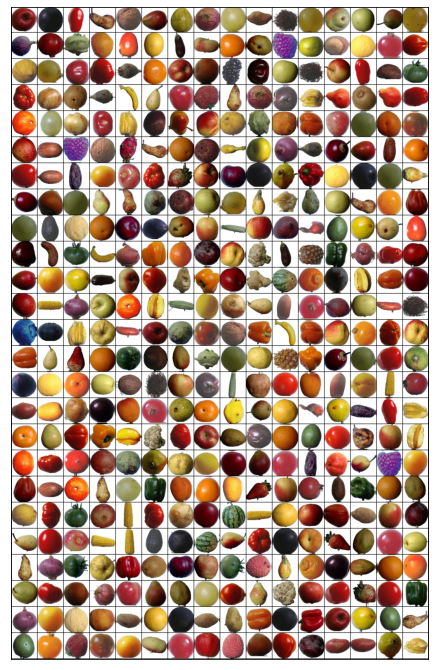

In [13]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

show_batch(train_loader)

Can you label all the images by looking at them? Trying to label a random sample of the data manually is a good way to estimate the difficulty of the problem, and identify errors in labeling, if any

[back to top](#Top)

#<a name="gpu"></a> **6: Accessing GPU**

---




You can use a Graphics Processing Unit (GPU) to train your models faster if your execution platform is connected to a GPU manufactured by NVIDIA. Follow these instructions to use a GPU on the platform of your choice:

- Google Colab: Use the menu option "Runtime > Change Runtime Type" and select "GPU" from the "Hardware Accelerator" dropdown.
- Kaggle: In the "Settings" section of the sidebar, select "GPU" from the "Accelerator" dropdown. Use the button on the top-right to open the sidebar.
- Binder: Notebooks running on Binder cannot use a GPU, as the machines powering Binder aren't connected to any GPUs.
- Linux: If your laptop/desktop has an NVIDIA GPU (graphics card), make sure you have installed the NVIDIA CUDA drivers.
- Windows: If your laptop/desktop has an NVIDIA GPU (graphics card), make sure you have installed the NVIDIA CUDA drivers.
macOS: macOS is not compatible with NVIDIA GPUs
- If you do not have access to a GPU or aren't sure what it is, don't worry, you can execute all the code in this tutorial just fine without a GPU.

Let's begin by installing and importing the required libraries.

In [14]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Now I load the train and validation loaders to GPU using the `DeviceDataLoader` function

In [15]:
device = get_default_device()
device

train_dl = DeviceDataLoader(train_loader, device)
valid_dl = DeviceDataLoader(val_loader, device)

[back to top](#Top)

#<a name="Configuration"></a> **7: Configuring the model**


---



## 7.1: Setting up Accuracy function and Image base class

Both are generic function and does not require any changes to be made regardless of the datasets.

In [16]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [17]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['train_loss'], result['val_loss'], result['val_acc']))

## 7.2 Implementing Batch normalization and Dropout

In [18]:
# # Only run this cell if u want to reset the model parameters
# def weight_reset(m):
#     if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
#         m.reset_parameters()

# model.apply(weight_reset)

We use `nn.Squential` to chain together the layers of neural network. I have added comments in the code to simply the understanding. **Note** - Here I have implemented batch normalization via `nn.BatchNorm2d` at the end of each layer.

In [19]:
class Fruit360CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(3, 32, kernel_size=3, padding=1), # 32 X 100 X 100
            nn.BatchNorm2d(32),
            nn.ReLU(), # 32 X 100 X 100
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # 64 X 50 X 50

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 25 x 25

            nn.Flatten(), 
            nn.Dropout(0.3),
            nn.Linear(128*25*25, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 131))
        
    def forward(self, xb):
      return self.network(xb)

model = Fruit360CnnModel()
model

Fruit360CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Flatten(start_dim=1, end_dim=-1)
    (15): Dropout(

## 7.3 Implementing Weight Decay, Gradient clipping, Adam optimizer while training

In [20]:
@torch.no_grad()

def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

# def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [21]:
model = to_device(model, device)
model

Fruit360CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Flatten(start_dim=1, end_dim=-1)
    (15): Dropout(

In [22]:
os.environ['WANDB_CONSOLE'] = 'off'

history = [evaluate(model, valid_dl)]
history


[{'val_acc': 0.0040511139668524265, 'val_loss': 4.87500524520874}]

[back to top](#Top)

#<a name="Results"></a> **8.Training the model and Result Analysis**

---



## 8.1 Setting up the parameters before training

In [23]:
epochs = 4
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

## 8.2: Running the model for 4 epochs

In [24]:
%%time

os.environ['WANDB_CONSOLE'] = 'off'

history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], train_loss: 0.3914, val_loss: 23.9026, val_acc: 0.0820
Epoch [1], train_loss: 0.1123, val_loss: 0.0890, val_acc: 0.9736
Epoch [2], train_loss: 0.0185, val_loss: 0.0044, val_acc: 0.9994
Epoch [3], train_loss: 0.0017, val_loss: 0.0007, val_acc: 1.0000
CPU times: user 21.3 s, sys: 13.6 s, total: 34.8 s
Wall time: 3min 28s


## 8.3 Accuracy vs No of epochs

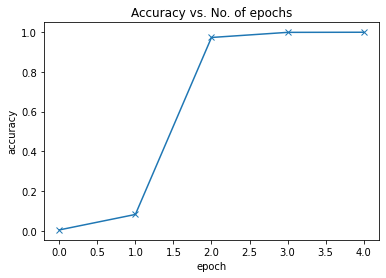

In [25]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

## 8.4 Loss vs epochs

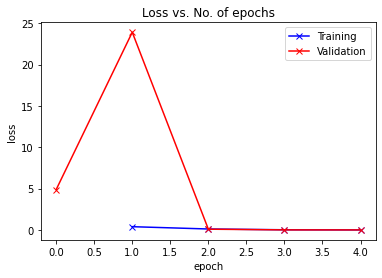

In [26]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

## 8.5 Learning rate with batch no

In [27]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

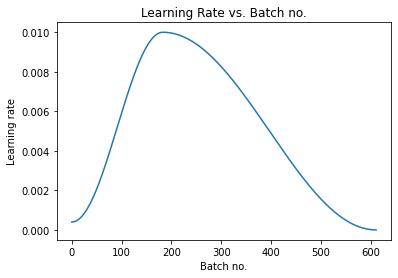

In [28]:
plot_lrs(history)

[back to top](#Top)

#<a name="Predictions"></a> **9.Predictions**

---




In [29]:
test_tfms = tt.Compose([tt.Resize((100, 100)), 
                        tt.ToTensor()])

In [30]:
test_dataset = ImageFolder(data_dir + "Test", transform=test_tfms)

In [31]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size), device)
result = evaluate(model, test_loader)
result

{'val_acc': 0.991622805595398, 'val_loss': 0.03312457352876663}

In [32]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: Apple Braeburn , Predicted: Apple Braeburn


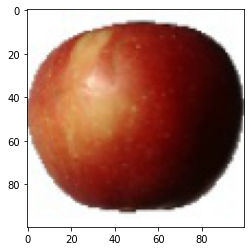

In [33]:
img, label = test_dataset[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: Apple Golden 2 , Predicted: Apple Golden 2


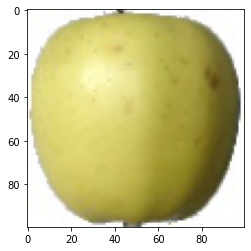

In [34]:
img, label = test_dataset[512]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: Banana Red , Predicted: Banana Red


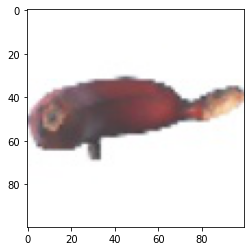

In [35]:
img, label = test_dataset[3015]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

[back to top](#Top)

#<a name="Summary"></a> **10.Summary**

---



Here's a summary of the different techniques used in this tutorial to improve our model performance and reduce the training time:

- Data augmentation: We applied random transformations while loading images from the training dataset. Specifically, we will pad each image by 4 pixels, and then take a random crop of size 100 x 100 pixels, and then flip the image horizontally with a 50% probability. 

- Batch normalization: After each convolutional layer, we added a batch normalization layer, which normalizes the outputs of the previous layer. This is somewhat similar to data normalization, except it's applied to the outputs of a layer, and the mean and standard deviation are learned parameters.

- Learning rate scheduling: Instead of using a fixed learning rate, we will use a learning rate scheduler, which will change the learning rate after every batch of training. There are many strategies for varying the learning rate during training, and we used the "One Cycle Learning Rate Policy".

- Weight Decay: We added weight decay to the optimizer, yet another regularization technique which prevents the weights from becoming too large by adding an additional term to the loss function. 

- Gradient clipping: We also added gradient clippint, which helps limit the values of gradients to a small range to prevent undesirable changes in model parameters due to large gradient values during training.

- Adam optimizer: Instead of SGD (stochastic gradient descent), we used the Adam optimizer which uses techniques like momentum and adaptive learning rates for faster training. There are many other optimizers to choose froma and experiment with. Learn more.

[back to top](#Top)